Credentials

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

# OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

OPENAI_API_KEY=os.getenv('AZURE_OPENAI_API_KEY_US')
OPENAI_API_KEY_E=os.getenv('AZURE_OPENAI_API_KEY_US2') 

# os.environ['OPENAI_API_TYPE'] = 'azure'
os.environ['OPENAI_API_VERSION'] = '2024-08-01-preview'
os.environ['AZURE_OPENAI_ENDPOINT'] = 'https://azure-chat-try-2.openai.azure.com/'
os.environ['AZURE_OPENAI_DEPLOYMENT'] = 'chat-endpoint-us-gpt4o'

os.environ['OPENAI_API_VERSION_E'] = '2024-12-01-preview'
os.environ['AZURE_OPENAI_ENDPOINT_E'] = 'https://agents-4on.openai.azure.com/'
os.environ['AZURE_OPENAI_EMBEDDING_DEPLOYMENT_E'] = "text-embedding-3-large-eus2"

# LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')
# os.environ['LANGCHAIN_TRACING_V2'] = 'true'
# os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
# os.environ['LANGCHAIN_PROJECT'] = "rag-sql"


LLM

In [2]:

from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings

llm = AzureChatOpenAI(
    api_key = OPENAI_API_KEY,  
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT")
)

emb_model = AzureOpenAIEmbeddings(
    api_key=OPENAI_API_KEY_E,
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT_E'),  
    api_version=os.getenv('OPENAI_API_VERSION_E'),
    azure_deployment=os.getenv('AZURE_OPENAI_EMBEDDING_DEPLOYMENT_E')
)

Database

In [ ]:
# Database

from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///./database/credit-risk.db", sample_rows_in_table_info=2)
print(db.dialect)
print(db.get_usable_table_names())

# engine = create_engine("sqlite:///./database/credit-risk.db", future=True)

sqlite
['collaterals', 'customers', 'sectors', 'transactions']


State

In [4]:
from typing import Any, Dict, List, TypedDict

class State(TypedDict):
    
    question: str
    # retrieved_docs: List[Dict[str, Any]]
    etrieved_docs: List[str]
    query: str
    result: str
    answer: str

### Nodes

RAG

In [5]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="risk_db_tables",
    embedding_function=emb_model,
    persist_directory="./vector_db"
)

# retriever = vector_store.as_retriever()

In [25]:
# Check retrieval

# from langchain_core.prompts import ChatPromptTemplate
# from langchain_core.output_parsers import StrOutputParser
# from langchain_core.runnables import RunnablePassthrough

# template = """write an sql query that answers the question and uses the rertrieved database info:
# {context}

# Question: {question}
# """

# prompt = ChatPromptTemplate.from_template(template)

# rag_chain = (
#     {"context": retriever, "question": RunnablePassthrough()}
#     | prompt
#     | llm
#     | StrOutputParser()
# )


# res = rag_chain.invoke("What is the total drawn exposure per corporate rating model and in the Agriculture sector for September 2023?")
# print(res)

# print('---------------------------')

# docs = retriever.vectorstore.similarity_search('What is the total off-balance exposure for September 2023?')
# print(docs)

Node: Retriever

In [26]:
def db_retriever(state: State):

    question = state["question"]

    docs = vector_store.similarity_search(question, k=5)

    snippets = []
    for d in docs:
        src = d.metadata.get("source", "unknown")
        snippets.append(f"Source: {src}\n{d.page_content}")
    return {"retrieved_docs": snippets} 


# ********************************************


# def db_retriever(state: State):
    
#     question = state["question"]

#     results = vector_store.similarity_search(question)
#     docs_serial = [
#         {"table": d.metadata.get("table"), "source_file": d.metadata.get("source_file"), "snippet": d.page_content[:1500]}
#         for d in results
#     ]

#     return {"retrieved_docs": docs_serial}


# def db_retriever(state: State) -> State:
    
#     question = state["question"]

#     results = vector_store.similarity_search(question)
#     docs_serial = [
#         {"table": d.metadata.get("table"), "source_file": d.metadata.get("source_file"), "snippet": d.page_content[:800]}
#         for d in results
#     ]

#     state['retrieved_docs'] = docs_serial

#     return state

Node: Convert question (+ schema) to SQL query (write query)

In [13]:
from typing_extensions import Annotated

write_query_instructions = """
You are a SQL expert with a strong attention to detail.

Given an input question, create a syntactically correct SQLite query to run to help find the answer. 

When generating the query:

Unless the user specifies in his question a specific number of examples they wish to obtain, limit your query to at most 3 results. 
For example, if the user asks for the top 5 results, you should NOT limit the query to 3 results.

You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the retrieved database description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

Only use the following tables:
{retrieved_docs}

Question: {question}
"""

class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]

def write_query(state: State):
    """Generate SQL query to fetch information."""

    question = state["question"]
    retrieved_docs = state["retrieved_docs"]
    
    prompt = write_query_instructions.format(
        question = question,
        retrieved_docs = retrieved_docs        
    ) 

    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

Node: Execute query

In [14]:
def run_query(state: State):
    query = state['query']
    result = db.run_no_throw(query)
    return {"result": result}

Node: Generate answer

In [29]:
answer_instructions = """
Given the user {question} and the query {result} compose a short but comprehensive final answer. 

You may present the final result in a tabluar form, If the result from the query suggests so.
"""

def generate_answer(state: State):

    question = state["question"]
    result = state.get("result", None)

    prompt = answer_instructions.format(
        question=question,
        result=result
    )   

    response = llm.invoke(prompt) 

    return {"answer": response.content}

#### Flow

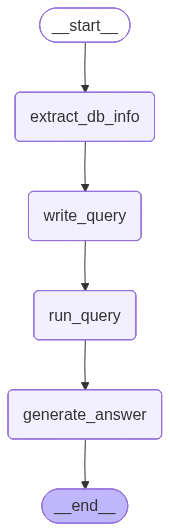

In [39]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

builder = StateGraph(State)

builder.add_node('extract_db_info', db_retriever)
builder.add_node('write_query', write_query)
builder.add_node('run_query', run_query)
builder.add_node('generate_answer', generate_answer)

builder.add_edge(START, 'extract_db_info')
builder.add_edge('extract_db_info', 'write_query')
builder.add_edge('write_query', 'run_query')
builder.add_edge('run_query', 'generate_answer') 
builder.add_edge('generate_answer', END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
question = 'What is the total drawn exposure for each corporate rating model and in the Agriculture sector for September 2023?'

config = {"configurable": {"thread_id": "0"}}
question = {"question": question}

for event in graph.stream(question, config, stream_mode="updates"):
    print(event)

{'extract_db_info': {'retrieved_docs': ["Source: unknown\nTable: customers\nDescription: Stores information on customer level\n\nColumns:\n- REF_DATE (DATE) - nullable=False\n  Description: Reference date (sometimes referred to as 'reporting date'), the last working date of the month in 'DD-MM-YYYY' format.\n- PARTNER_ID (TEXT) - nullable=False\n  Description: The indetifier/number of the client. The client is ofter referred to as 'borrower', 'customer' or 'partner'.\n- STATUS (TEXT) - nullable=False\n  Description: The status of the client, indicating if their obligations are regularly served\n  Allowed values: P: Performing status, the loan is regularly served., D: The client is in default\n- PD (REAL) - nullable=False\n  Description: Probability of Defualt of the customer.\n- COUNTRY (TEXT) - nullable=True\n  Description: The country of residence of the customer.\n  Allowed values: AT: Austria, BG: Bulgaria, CA: Canada, CY: Cyprus, NL: Netherlands \n- RATING_MODEL (TEXT) - nullable=